In [1]:
import os
import pandas as pd
import logging

logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )

In [2]:
os.chdir('../')

In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
# Define cDNA file
cdna_p = '/home/xlv0877/proj_home/ExPert/resources/misc/Homo_sapiens.GRCh38.cdna.all.fa.gz'

In [5]:
from src.utils.dna import read_fasta, subset_fasta

In [6]:
# Get fasta entries
fasta = read_fasta(cdna_p)

Reading fasta: 207133entries [00:06, 32387.78entries/s]


In [7]:
# Define target genes
targets = [
    'ANAPC15',
     'BCAR1',
     'CACNB3',
     'CADM4',
     'ESPN',
     'GAB2',
     'GFM1',
     'GTF3C4',
     'MRPL35',
     'MRPL36',
     'MYBL2',
     'NBPF12',
     'PPP2R1A',
     'PPP6C',
     'PRODH',
     'PSMG3',
     'SLC1A5',
     'SRSF11',
     'TARDBP',
     'control'
]
target_fasta = subset_fasta(fasta, targets=targets)

In [66]:
from Bio import SeqIO
# save target fasta file
target_p = 'data/target_fasta.fa'

SeqIO.write(target_fasta.values(), target_p, 'fasta')

19

In [ ]:
# extract target sequences
target_seqs = [t.seq for t in target_fasta.values()]

In [11]:
# Read aligned fasta
from Bio import AlignIO

align_p = '/home/xlv0877/proj_home/dl/data/aligned.fasta'
alignment = AlignIO.read(align_p, 'fasta')

In [12]:
from src.utils.dna import read_alignment

headers, seqs = read_alignment(align_p)

Reading fasta: 3838lines [00:00, 1483115.79lines/s]


In [13]:
# Add control to dataset
msa_len = len(seqs[0])
ctrl_header = 'control'
ctrl_seq = '-' * msa_len
headers.append(ctrl_header)
seqs.append(ctrl_seq)

In [14]:
# Transform data to one-hot encoding
from src.utils.dna import one_hot_encode

ohe = one_hot_encode(seqs)

In [339]:
from src.utils.dna import fasta_to_matrix
# convert data to matrix with nucleotide map (a: 1, c: 2, t: 3, g: 4, n: 0)
target_matrix = fasta_to_matrix(sequences=seqs)

In [58]:
import anndata as ad

# Add control index
obs = pd.DataFrame({'perturbation': headers})
target_adata = ad.AnnData(X=ohe.reshape(ohe.shape[0], -1), obs=obs)
# Add one-hot encoding of data to adata
target_adata.obsm['ohe'] = ohe

/home/xlv0877/.local/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [59]:
import scanpy as sc

logging.info('PCA')
sc.pp.pca(target_adata, n_comps=50, zero_center=False)

2025-04-08 18:08:23,062 - INFO - PCA


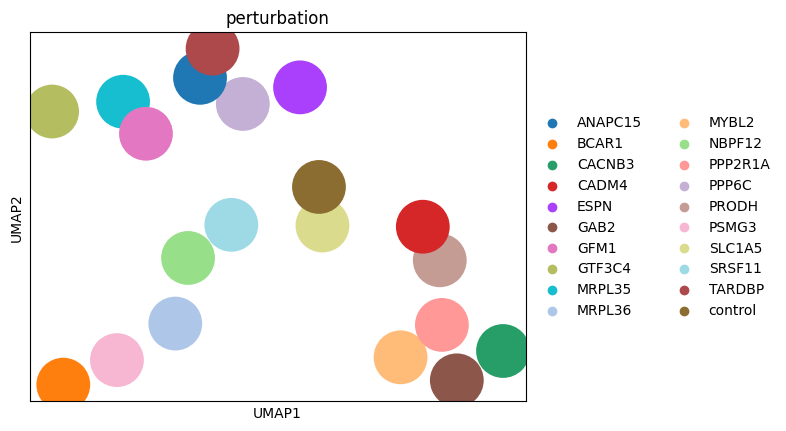

In [60]:
target_adata.obs['perturbation'] = target_adata.obs['perturbation'].astype('category')
sc.pp.neighbors(target_adata, n_neighbors=2, n_pcs=-1)
sc.tl.umap(target_adata)
sc.pl.umap(target_adata, color='perturbation')

In [136]:
# Load actual scRNA-seq data
adata_p = '/home/xlv0877/proj_home/dl/data/use_raw:True;min_cells:all;n_samples:50;n_perts:20;log1p:False;scale:False.h5ad'
adata = sc.read(adata_p)

In [137]:
# Pre-processing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [196]:
from src.common import center_on_ctrl

# Center the data on (X - mean_c) / var_c
center_on_ctrl(adata)

In [197]:
from src.sampling import sample_from_ctrl_cells

adata = sample_from_ctrl_cells(adata, cls_labels=['dataset', 'perturbation'], n_ctrl=2000).copy()

/home/xlv0877/.conda/envs/ExPert/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 15639 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


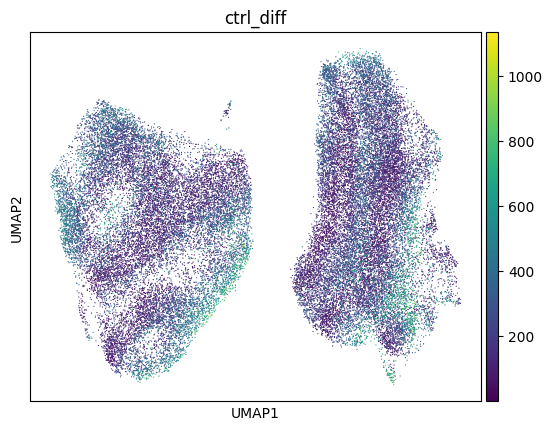

In [199]:
logging.info('PCA')
sc.pp.pca(adata)
logging.info('Neighbors')
sc.pp.neighbors(adata)
logging.info('UMAP')
sc.tl.umap(adata)
logging.info('Plotting')
sc.pl.umap(adata, color='ctrl_diff')

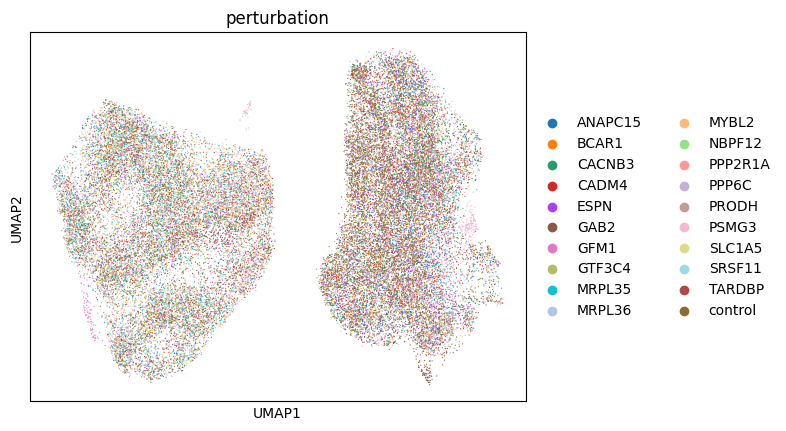

In [200]:
sc.pl.umap(adata, color='perturbation')

In [381]:
# Create mapping of adata indices to msa sequences
adata_map = (
    adata.obs[['dataset', 'perturbation', 'ctrl_diff']]
    .reset_index()
    .merge(target_adata.obs.reset_index(names='msa_idx'), on='perturbation')
)

In [382]:
# overload 
target_adata = target_adata[adata_map['msa_idx'],:].copy()
# Add ctrl difference
target_adata.obs['ctrl_diff'] = adata_map['ctrl_diff'].values
target_adata.obs.index = adata_map['index'].values

/home/xlv0877/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [383]:
# Scale each cell's one-hot encoding to the actual 'dosage' of the perturbation
target_adata.obsm['ohe'] *= np.array(adata_map['ctrl_diff'])[:, np.newaxis, np.newaxis]

In [384]:
from scipy.sparse import diags

# Scale MSA sequences by the observed difference to control --> simulates dosage
cell_diff_mult = np.array(adata_map['ctrl_diff'])[:, np.newaxis]
row_factors = np.ravel(cell_diff_mult)
D = diags(row_factors)
target_adata.X = D.dot(target_adata.X)

KeyError: 'Could not find key ctrl_diff in .var_names or .obs.columns.'

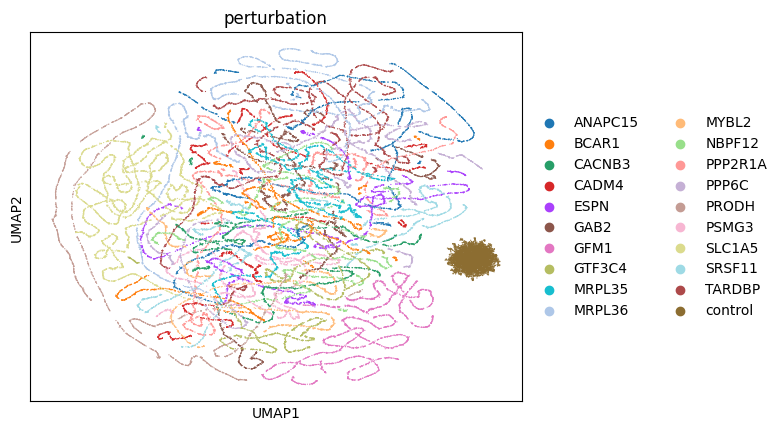

In [282]:
logging.info('PCA')
sc.pp.pca(target_adata)
logging.info('Neighbors')
sc.pp.neighbors(target_adata)
logging.info('UMAP')
sc.tl.umap(target_adata)

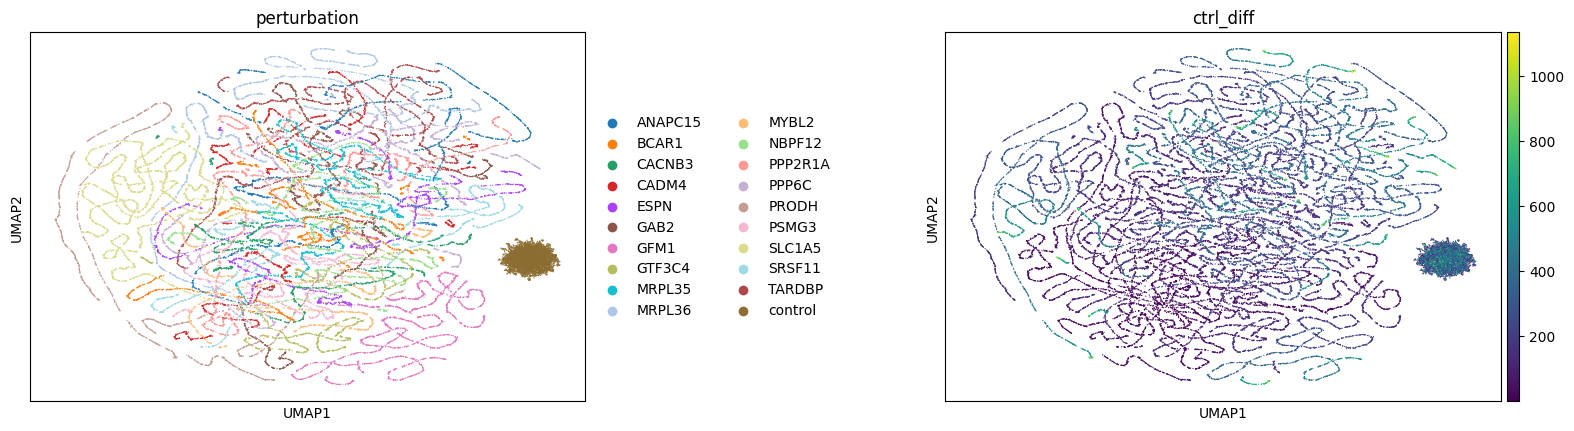

In [297]:
logging.info('Plotting')
sc.pl.umap(target_adata, color=['perturbation', 'ctrl_diff'], wspace=0.5)

In [393]:
# Reshape one?-hot encoding to 2d matrix and save in adata
target_adata.obsm['ohe_2d'] = sp.csr_matrix(
    target_adata.obsm['ohe'].reshape(target_adata.shape[0], -1)
)

In [394]:
# Save multi-modal data
out_p = '/home/xlv0877/proj_home/dl/data/dna/msa_ctrl_diff.h5ad'
target_adata.write_h5ad(out_p)

In [4]:
# Load the created dataset and plot it
import scanpy as sc

in_p = '/home/xlv0877/proj_home/dl/data/dna/msa_ctrl_diff.h5ad'
target_adata = sc.read(in_p)

/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx

In [5]:
# Calculate PCA on ohe 2d projection
target_adata.obsm['ohe_2d_pca'] = sc.pp.pca(target_adata.obsm['ohe_2d'], return_info=False, n_comps=50)

In [6]:
sc.pp.neighbors(target_adata, use_rep='ohe_2d_pca')

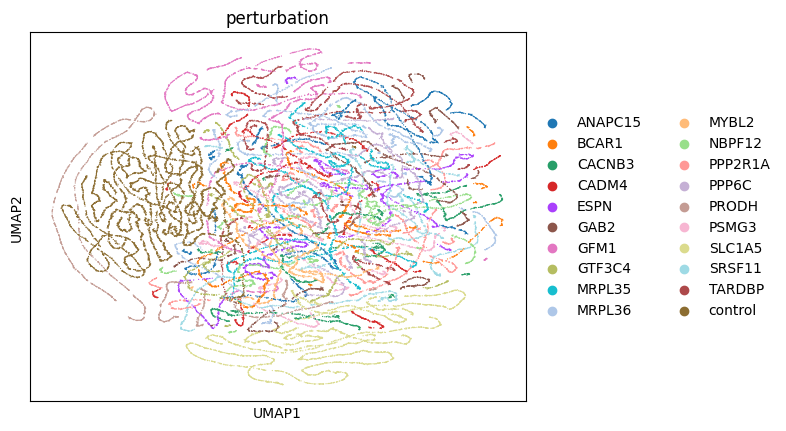

In [7]:
sc.tl.umap(target_adata)
sc.pl.umap(target_adata, color='perturbation')

In [10]:
# Plot actual data
target_adata.obsm['ohe_2d']

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 482406996 stored elements and shape (40107, 72168)>

In [21]:
# reshape to 2d
ohe2d = ohe.reshape(ohe.shape[0], -1)

In [45]:
ohe_summary = pd.DataFrame(ohe.sum(axis=1), index=headers)

In [51]:
nuc_map = {'-': 0, 'N': 1, 'A': 2, 'C': 3, 'G': 4, 'T': 5}

In [52]:
ohe_summary.columns = nuc_map.keys()

In [55]:
pl_df = ohe_summary.reset_index(names='perturbation').melt(id_vars='perturbation')